# LatentMan : Generating Consistent Animated Characters using Image Diffusion Models
The generation process has 3 stages:
1. Generating a sequence of animated SMPL models using MDM.
2. Rendering the SMPL models to obtain depth maps and DensePose.
3. Generate the video frames.

We provide some pre-generated examples for 1, 2, so you can jump directly to 3.

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import sys 
from external.config import CWD, MDM_PATH, T2M_MODEL_PATH, A2M_MODEL_PATH, DATASETS_PATH, DENSEPOSE_PATH
sys.path.extend([f"{CWD}/external",MDM_PATH,DENSEPOSE_PATH])


## 1- Generate new Animation using Motion Diffusion Model ([MDM](https://github.com/GuyTevet/motion-diffusion-model/tree/main))

In [2]:

from external.mdm.utils.parser_util import generate_args
from external.mdm_generator import load_data_and_model, generate_motion, smplify,export_obj, SUPPORTED_ACTIONS

# Choose from two modes Text2Action (T2M) or Action2Motion (A2M)
# T2M is a free text, while A2M is a single word from the pre-defined list of actions
MODE = "a2m"

if MODE == "t2m":
    MODEL_PATH = T2M_MODEL_PATH
elif MODE == "a2m":
    MODEL_PATH = A2M_MODEL_PATH 
    print("Supported actions are: ", SUPPORTED_ACTIONS)

##### MDM Arguments #######
num_samples = 1
num_frames = 60
args = generate_args(MODEL_PATH)
args.model_path = MODEL_PATH
args.data_dir = DATASETS_PATH
args.batch_size = num_samples
args.num_samples = num_samples
args.num_repetitions = 1 
args.motion_length = 3 # Motion length in seconds

model, diffusion, data = load_data_and_model(args, num_samples, num_frames)

Supported actions are:  ['warm_up', 'walk', 'run', 'jump', 'drink', 'lift_dumbbell', 'sit', 'eat', 'turn steering wheel', 'phone', 'boxing', 'throw']
/datawaha/cggroup/eldesoa/code/latentman/external/mdm/save/humanact12/args.json
Loading dataset...
Creating model and diffusion...
TRANS_ENC init
EMBED ACTION


/datawaha/cggroup/eldesoa/miniconda3/envs/latentman/lib/python3.8/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Loading checkpoints from [/datawaha/cggroup/eldesoa/code/latentman/external/mdm/save/humanact12/model000350000.pt]...


### Sampling [repetitions #0]


  0%|          | 0/1000 [00:00<?, ?it/s]

created 1 samples
saving results file to [/datawaha/cggroup/eldesoa/code/latentman/workspace/jump_42/results.npy]
saving visualizations to [/datawaha/cggroup/eldesoa/code/latentman/workspace/jump_42]...
[Done] Results are at [/datawaha/cggroup/eldesoa/code/latentman/workspace/jump_42]


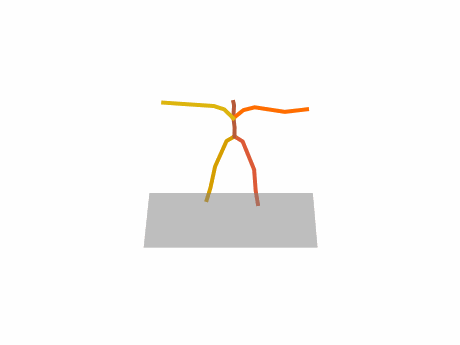

In [5]:
from IPython.display import Image

motion_prompt = "jump"
motion_seed = 42

if MODE == "t2m":
    args.text_prompt = motion_prompt
    args.dataset = "humanml"
elif MODE == "a2m":
    assert motion_prompt in SUPPORTED_ACTIONS, f"This action is not supported! \n Please choose from {SUPPORTED_ACTIONS}"
    args.action_name = motion_prompt
    args.dataset = "humanact12"

args.seed = motion_seed

npy_path, gif_path = generate_motion(model, diffusion, data, args)
Image(gif_path)


In [6]:
#### Fit SMPLX model if you are happy with the generated motion ###
smplify(npy_path)
export_obj(motion_prompt, motion_seed, task=MODE)


Converting to 'neutral' SMPL Body Models ...
/datawaha/cggroup/eldesoa/code/latentman/external/mdm/body_models
Running SMPLify For sample [0], repetition [-1], it may take a few minutes.


/datawaha/cggroup/eldesoa/code/latentman/external/mdm/visualize/simplify_loc2rot.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  root_loc = torch.tensor(keypoints_3d[:, 0])  # [bs, 3]


Saved to /datawaha/cggroup/eldesoa/code/latentman/workspace/jump_42/results.pkl!


  0%|          | 0/60 [00:00<?, ?it/s]

# 2- Render the Generated Animation 

In [7]:
from external.renderer import init_renderer, render_motion
from external.densepose_detector import load_densepose_model, detect_densepose

res = 512
densepose_model = load_densepose_model("resnet50")
renderer = init_renderer([res,res])

Loading DensePose with Backbone `resnet50`


Rendering 'jump_42'


  0%|          | 0/60 [00:00<?, ?it/s]

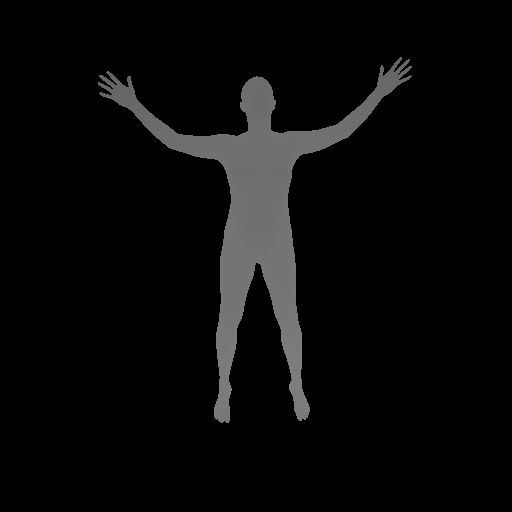

Detecting DensePose ..
Done DensePose!


In [15]:
motion_prompt_w_seed = motion_prompt + f"_{motion_seed}"
print(f"Rendering '{motion_prompt_w_seed}'")        
rendered_images, depth_images = render_motion(renderer, motion_prompt_w_seed, normalize="none", use_persp=True, cam_dist=3.0, show_render=True) 
_ = detect_densepose(densepose_model, rendered_images, motion_prompt_w_seed)

# 3- Generate the video frames

In [16]:

import torch
import numpy as np
from diffusers.models.controlnet import ControlNetModel

from pipelines.pipeline_latentman import StableDiffusionLatentMan
from pipelines.scheduling_ddim import DDIMScheduler
from misc.cross_frame_attn import CrossFrameAttnProcessor

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
dtype = torch.float16

controlnet_depth = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=dtype) 
pipe = StableDiffusionLatentMan.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet_depth, torch_dtype=dtype, scheduler=scheduler
)
pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload(gpu_id=0)

# Cross-frame attention
cross_frame_processor = CrossFrameAttnProcessor(unet_chunk_size=2)
pipe.unet.set_attn_processor(processor=cross_frame_processor)
pipe.controlnet.set_attn_processor(processor=cross_frame_processor)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [17]:
import matplotlib.pyplot as plt
from external.mdm.utils.fixseed import fixseed
from moviepy.editor import ImageSequenceClip, ipython_display
from torchvision.utils import make_grid
from inference import load_motion,get_dense_correspond, added_prompt, negative_prompt

generator = torch.Generator(device="cuda")
BATCH_SIZE = 24 # This batch size needs a GPU with 40 GB of memory, Otherwise, you can reduce it!
SKIP=1  ## A step for skipping frames


########### LatentMan Parameters ################
reference_mode = "prev_new"  # prev | first | prev_new
inference_steps = 100
latent_alignment_steps = range(40)
pixel_wise_guidance_steps = range(0)
rho = 0.01
correspondence_res = [64, 256] if pixel_wise_guidance_steps else [64]
   
        
########### Load Guidance Data and Define Prompt ################
motion_prompt = "valz_dance_5"  # <motion_ptompt>_<seed>
prompt = "An Stormtrooper dances valz" 
seed = 45
start_from = 0  # Which frame to start from
shift_x = 0   # Shift the depth maps horizontally
shift_y = 40 # Shift the depth maps vertically

dps, guidance_imgs, batches, motion_dir, out_dir = load_motion(motion=motion_prompt, prompt=prompt, seed=seed, start_from=start_from, shift_x=shift_x, shift_y=shift_y, batch_size=BATCH_SIZE,skip=SKIP) 


########### Compute Dense Correspondences ################
xy_xy_dict = {}
new_dps_dict = {}        
for new_res in correspondence_res:
    new_dps, xy_xy = get_dense_correspond(dps, new_res, reference_mode, motion_dir, num_dps=BATCH_SIZE)
    new_dps_dict[new_res] = new_dps
    xy_xy_dict[new_res] = xy_xy
    

########### Generate ################
prompts = prompt + ", " + added_prompt

    
fixseed(seed)                   
generator.manual_seed(seed)

ident = f"latentman_"
ident = ident + f"L[{min(latent_alignment_steps)},{max(latent_alignment_steps)}]" if latent_alignment_steps else ident+"L[]"
ident = ident + f"_X[{min(pixel_wise_guidance_steps)},{max(pixel_wise_guidance_steps)}]" if pixel_wise_guidance_steps else ident+"_X[]"
ident = ident + f"_r{rho}_{reference_mode}_B{BATCH_SIZE}"
print(out_dir, ident)       


start_code = torch.randn([1, 4, 64, 64], generator=generator, device=device).to(dtype)

# # inference the synthesized image
out = []
for i, batch in enumerate(batches):        
    
    latents = start_code.repeat(len(batch), 1, 1, 1)   
    img_new = pipe(
        [prompts]*len(batch),
        [batch/255],
        latents=latents,
        num_inference_steps=inference_steps,
        generator=generator,
        negative_prompt=[negative_prompt]*len(batch),
        controlnet_conditioning_scale=1.0,
        guidance_scale=9.0,
        sla_steps = latent_alignment_steps,
        pwg_steps = pixel_wise_guidance_steps,
        rho=rho,
        dps_low=xy_xy_dict,
        reference_mode=reference_mode,                
    ).images

    out = [np.asarray(img) for img in img_new ]

    # The code only supports processing the first batch, but can be extended 
    # for more batches in an autoregreissve manner
    if i == 0 :     
        break

out_path =f'{out_dir}/mp4/{ident}.mp4'
vid = ImageSequenceClip(out, fps=10)
vid.write_videofile(out_path)
img_collage = make_grid([torch.as_tensor(np.asarray(img).transpose(2,0,1)) for img in img_new], padding=10, pad_value=255).permute(1,2,0).numpy()
plt.imsave(out_path.replace("mp4", "png"), img_collage)
print(f"Saved to {out_path}")
ipython_display(vid)

==> Motion: valz_dance_5, 	 start_from: 0, 	 shift_x: 0, 	 shift_y: 40
60 60
Using `prev_new` reference: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


  0%|          | 0/23 [00:00<?, ?it/s]

24 24
/datawaha/cggroup/eldesoa/code/latentman/workspace/valz_dance_5/An_Stormtrooper_dances_valz_s45_x0_y40_f0 latentman_L[0,39]_X[]_r0.01_prev_new_B24


  0%|          | 0/100 [00:00<?, ?it/s]

Moviepy - Building video /datawaha/cggroup/eldesoa/code/latentman/workspace/valz_dance_5/An_Stormtrooper_dances_valz_s45_x0_y40_f0/mp4/latentman_L[0,39]_X[]_r0.01_prev_new_B24.mp4.
Moviepy - Writing video /datawaha/cggroup/eldesoa/code/latentman/workspace/valz_dance_5/An_Stormtrooper_dances_valz_s45_x0_y40_f0/mp4/latentman_L[0,39]_X[]_r0.01_prev_new_B24.mp4



Moviepy - Done !
Moviepy - video ready /datawaha/cggroup/eldesoa/code/latentman/workspace/valz_dance_5/An_Stormtrooper_dances_valz_s45_x0_y40_f0/mp4/latentman_L[0,39]_X[]_r0.01_prev_new_B24.mp4
Saved to /datawaha/cggroup/eldesoa/code/latentman/workspace/valz_dance_5/An_Stormtrooper_dances_valz_s45_x0_y40_f0/mp4/latentman_L[0,39]_X[]_r0.01_prev_new_B24.mp4
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
